In [102]:
from astropy.io import fits
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import aplpy
from astropy import units as u
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
import pandas as pd
pd.set_option('display.max_columns', 100)
import seaborn as sns
sns.set(font="times",font_scale=1.3,style="ticks")
import matplotlib as mpl
mpl.rc('text', usetex=True)
from zero_point import zpt
zpt.load_tables()
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
def Ks2R(Ks):
    # Mann+2015, < 4500K
    a = 1.9515
    b = -0.3520
    c = 0.01680
    R = a + b*Ks + c*Ks**2
    return R
def BC_K(Teff):
    # Bolometric correction for K-band
    # https://arxiv.org/pdf/astro-ph/0601049.pdf
    slope=(0.385-1.305)/2000
    BC = slope*(Teff-6000) + 1.305
    return BC

In [103]:
catalog = pd.read_csv("../files/cluster_search.csv")
from scipy import interpolate
maglim_H120s = np.load("../files/maglim_H120s.npy")
maglim_H300s = np.load("../files/maglim_H300s.npy")
maglim_J120s = np.load("../files/maglim_J120s.npy")
maglim_J300s = np.load("../files/maglim_J300s.npy")
f_H120s = interpolate.interp1d(maglim_H120s[0],maglim_H120s[1],fill_value="extrapolate")
f_H300s = interpolate.interp1d(maglim_H300s[0],maglim_H300s[1],fill_value="extrapolate")
f_J120s = interpolate.interp1d(maglim_J120s[0],maglim_J120s[1],fill_value="extrapolate")
f_J300s = interpolate.interp1d(maglim_J300s[0],maglim_J300s[1],fill_value="extrapolate")

In [122]:
T_sun = 5778
RJ2RSun = 0.103
RE2RSun = 6378/6.96/1e+5
RN2RSun = RE2RSun*3.8
sigma=10

Num_E120 = np.array([])
Num_N120 = np.array([])
Num_J120 = np.array([])
Num_E300 = np.array([])
Num_N300 = np.array([])
Num_J300 = np.array([])
Nstar = np.array([])

for name in catalog.Cluster:
    Name = name.replace(" ","")
    d = pd.read_csv("../match_final/"+Name+".csv")
    # radius is True
    c_val1 = d[~np.isnan(d.radius_val)]
    R_val1 = np.array(c_val1.radius_val.values,dtype="float")
    K_val1 = np.array(c_val1.ks_m.values,dtype="float")
    H_val1 = np.array(c_val1.h_m.values,dtype="float")
    BPRP_val1 = np.array(c_val1.bp_rp.values,dtype="float")
    # radius is False & Teff is True & Parallax is True
    c_val2    = d[np.isnan(d.radius_val)&(~np.isnan(d.teff_val))&(d.parallax.values>0)]
    MK_val2   = c_val2.ks_m.values - 5*np.log10(100/c_val2.parallax.values)
    L_val2    = 10**((-0.4)*(MK_val2+BC_K(c_val2.teff_val.values)-4.74)) 
    R_val2    = np.sqrt(L_val2)*(T_sun/c_val2.teff_val.values)**2
    K_val2    = np.array(c_val2.ks_m.values,dtype="float")
    H_val2    = np.array(c_val2.h_m.values,dtype="float")
    BPRP_val2 = np.array(c_val2.bp_rp.values,dtype="float")
    # radius is False & Teff is False & Parallax is True
    c_val3    = d[np.isnan(d.radius_val)&(np.isnan(d.teff_val))&(d.parallax.values>0)]
    MK_val3   = c_val3.ks_m.values - 5*np.log10(100/c_val3.parallax.values)
    R_val3    = Ks2R(MK_val3)
    K_val3    = np.array(c_val3.ks_m.values,dtype="float")
    H_val3    = np.array(c_val3.h_m.values,dtype="float")
    BPRP_val3 = np.array(c_val3.bp_rp.values,dtype="float")
    
    R_val    = np.hstack([R_val1,R_val2,R_val3])
    K_val    = np.hstack([K_val1,K_val2,K_val3])
    H_val    = np.hstack([H_val1,H_val2,H_val3])
    BPRP_val = np.hstack([BPRP_val1,BPRP_val2,BPRP_val3])
    
    # depth 
    Dep_E_val = (RE2RSun/R_val)**2
    Dep_N_val = (RN2RSun/R_val)**2
    Dep_J_val = (RJ2RSun/R_val)**2
    #S/N factor by transit duration
    fac = np.sqrt(4*60/5)
    fac2 = np.sqrt(4*60/2)
    # photometric precision
    Prec_H_120s = f_H120s(H_val)
    Prec_H_300s = f_H300s(H_val)
    # num
    count_E120 = np.where(fac*Dep_E_val>sigma*Prec_H_120s,1,0)
    count_N120 = np.where(fac*Dep_N_val>sigma*Prec_H_120s,1,0)
    count_J120 = np.where(fac*Dep_J_val>sigma*Prec_H_120s,1,0)
    count_E300 = np.where(fac*Dep_E_val>sigma*Prec_H_300s,1,0)
    count_N300 = np.where(fac*Dep_N_val>sigma*Prec_H_300s,1,0)
    count_J300 = np.where(fac*Dep_J_val>sigma*Prec_H_300s,1,0)
    
    Nstar = np.append(Nstar,len(count_E120))
    Num_E120=np.append(Num_E120,np.sum(count_E120))
    Num_N120=np.append(Num_N120,np.sum(count_N120))
    Num_J120=np.append(Num_J120,np.sum(count_J120))
    Num_E300=np.append(Num_E300,np.sum(count_E300))
    Num_N300=np.append(Num_N300,np.sum(count_N300))
    Num_J300=np.append(Num_J300,np.sum(count_J300))

In [217]:
age = 10**catalog.AgeNN

catalog_new = catalog.assign(Nstar_monitor=Nstar,
                             N120_J=Num_J120,N120_N=Num_N120,N120_E=Num_E120,
                             N300_J=Num_J300,N300_N=Num_N300,N300_E=Num_E300,age=age)
catalog_new.to_csv("../files/cluster_search_with_Ndetect.csv",index=False)

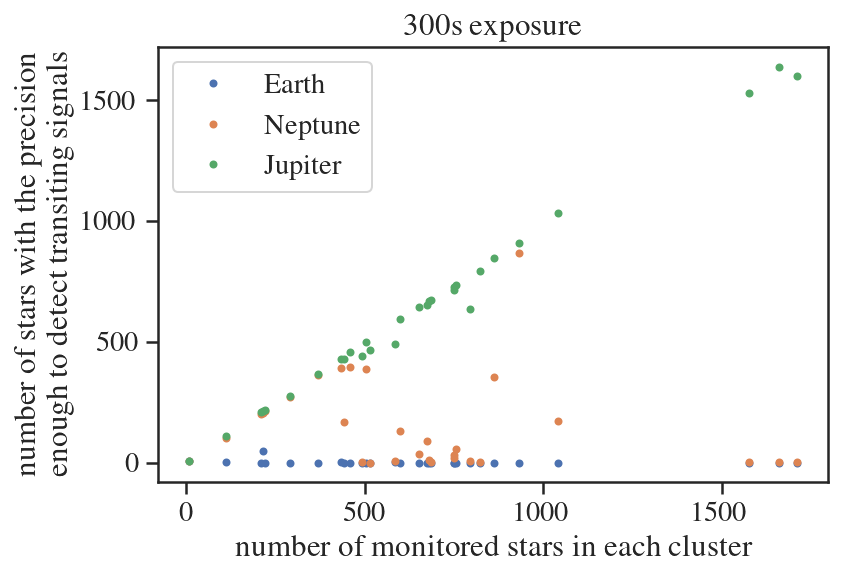

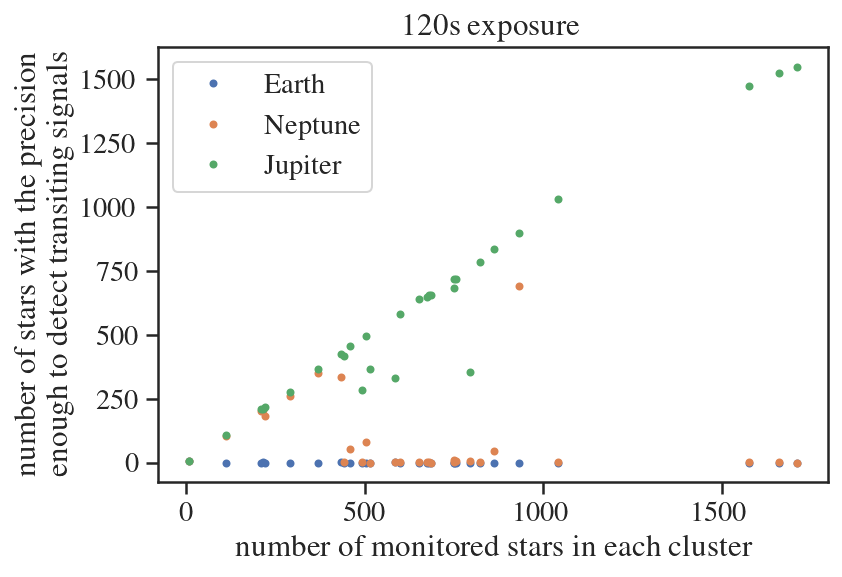

In [218]:
plt.plot(Nstar,Num_E300,".")
plt.plot(Nstar,Num_N300,".")
plt.plot(Nstar,Num_J300,".")
plt.title("300s exposure")
plt.legend(["Earth","Neptune","Jupiter"])
plt.xlabel("number of monitored stars in each cluster")
plt.ylabel("number of stars with the precision \n enough to detect transiting signals")

plt.subplots()
plt.plot(Nstar,Num_E120,".")
plt.plot(Nstar,Num_N120,".")
plt.plot(Nstar,Num_J120,".")
plt.legend(["Earth","Neptune","Jupiter"])
plt.title("120s exposure")
plt.xlabel("number of monitored stars in each cluster")
plt.ylabel("number of stars with the precision \n enough to detect transiting signals")
plt.show()

In [219]:
tmp = catalog_new.sort_values("N300_N",ascending=False)[0:10]
PRIME_SKY = np.load("../files/obs_fraction.npy")
l = np.where(PRIME_SKY[0]<180,PRIME_SKY[0],PRIME_SKY[0]-360)
b = PRIME_SKY[1]
lc = np.where(tmp.GLON.values<180,tmp.GLON.values,tmp.GLON.values-360)
bc = tmp.GLAT.values

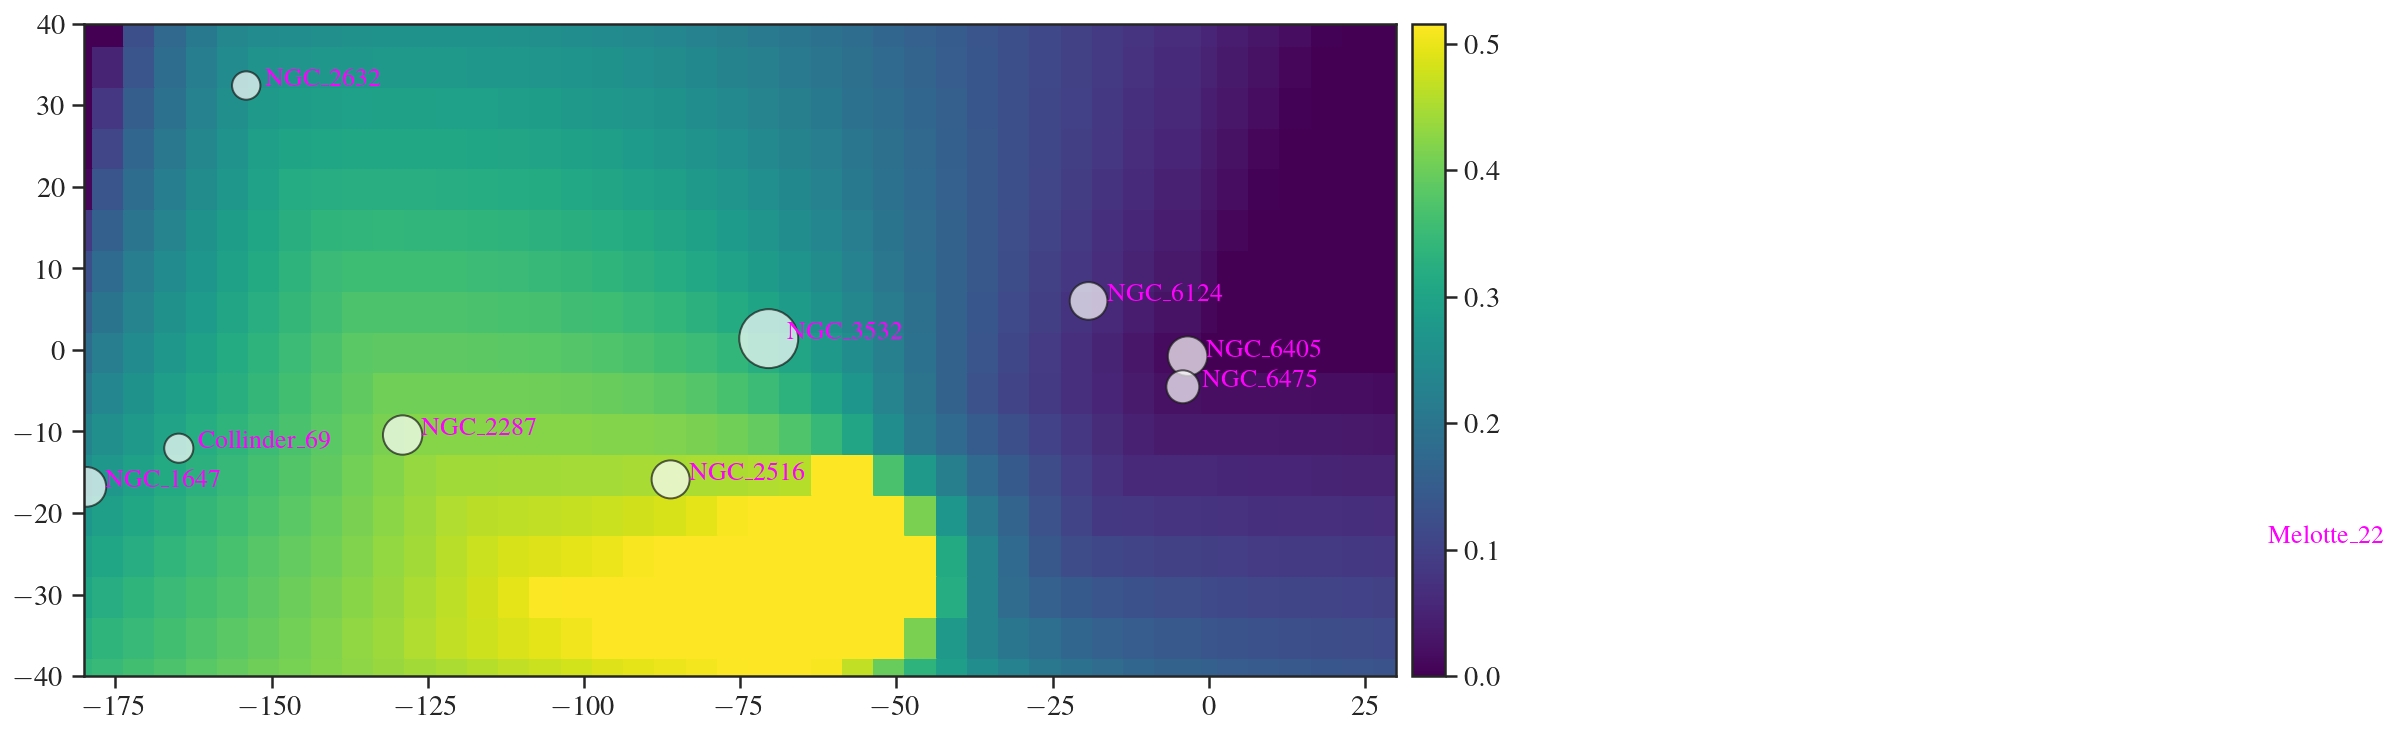

In [220]:
plt.subplots(figsize=(14,6))
plt.xlim(-180,30)
plt.ylim(-40,40)
sc = plt.scatter(l,b,c=PRIME_SKY[2],marker=",",s=500,alpha=1,cmap="viridis")
cb = plt.colorbar(sc,pad=0.01)
plt.scatter(lc,bc,s=tmp.N300_N,edgecolor="k",color="white",alpha=0.7)
for i in np.arange(len(tmp)):
    plt.text(lc[i]+3,bc[i],tmp.Cluster.values[i],c="magenta",zorder=20,size=13)

In [221]:
tmp = catalog_new.sort_values("N300_J",ascending=False)[0:10]
tmp

,index,Cluster,RA_ICRS,DE_ICRS,GLON,GLAT,r50,nbstars07,pmRA*,e_pmRA*,pmDE,e_pmDE,plx,e_plx,Flag,AgeNN,AVNN,DMNN,DistPc,X,Y,Z,Rgc,SimbadName,_RA.icrs,_DE.icrs,Nstar_monitor,N120_J,N120_N,N120_E,N300_J,N300_N,N300_E,age
12,849,NGC_2437,115.445,-14.844,-128.111,4.051,0.211,1733,-3.838,0.149,0.365,0.144,0.603,0.060,NaN,8.48,0.73,10.90,1511.0,-930.0,-1185.0,106.0,9345.0,NGC 2437,115.4450,-14.844,1661.0,1524.0,1.0,0.0,1634.0,4.0,0.0,3.019952e+08
14,857,NGC_2477,118.046,-38.537,-106.429,-5.838,0.150,1713,-2.449,0.169,0.870,0.192,0.665,0.037,NaN,9.05,0.68,10.80,1442.0,-405.0,-1376.0,-146.0,8853.0,NGC 2477,118.0460,-38.537,1712.0,1547.0,0.0,0.0,1596.0,3.0,0.0,1.122018e+09
6,788,NGC_2099,88.074,32.545,177.642,3.086,0.161,1648,1.924,0.201,-5.648,0.175,0.666,0.068,NaN,8.65,0.75,10.78,1432.0,-1429.0,58.0,77.0,9769.0,NGC 2099,88.0740,32.545,1577.0,1474.0,3.0,0.0,1526.0,4.0,0.0,4.466836e+08
8,794,NGC_2168,92.272,24.336,-173.391,2.230,0.319,1247,2.308,0.239,-2.905,0.235,1.131,0.064,NaN,8.17,0.46,9.79,906.0,-899.0,-104.0,35.0,9240.0,NGC 2168,92.2720,24.336,1042.0,1031.0,1.0,0.0,1033.0,173.0,0.0,1.479108e+08
19,901,NGC_3532,166.417,-58.707,-70.446,1.390,0.536,1854,-10.385,0.396,5.175,0.404,2.066,0.062,NaN,8.60,0.00,8.49,498.0,166.0,-469.0,12.0,8186.0,NGC 3532,166.4171,-58.707,933.0,900.0,689.0,0.0,909.0,868.0,0.0,3.981072e+08
23,950,NGC_6124,246.332,-40.661,-19.265,6.012,0.401,1273,-0.203,0.374,-2.094,0.352,1.557,0.073,NaN,8.28,1.93,9.08,654.0,614.0,-214.0,68.0,7728.0,NGC 6124,246.3320,-40.661,861.0,837.0,46.0,0.0,845.0,354.0,0.0,1.905461e+08
1,617,IC_2714,169.373,-62.719,-67.599,-1.784,0.171,888,-7.597,0.167,2.639,0.168,0.719,0.044,NaN,8.72,0.95,10.67,1360.0,518.0,-1257.0,-42.0,7922.0,IC 2714,169.3731,-62.719,824.0,784.0,2.0,0.0,790.0,3.0,0.0,5.248075e+08
2,621,IC_4651,261.212,-49.917,-19.896,-7.902,0.230,806,-2.410,0.213,-5.064,0.202,1.056,0.063,NaN,9.22,0.42,9.96,982.0,915.0,-331.0,-135.0,7432.0,IC 4651,261.2120,-49.917,755.0,718.0,5.0,0.0,733.0,55.0,0.0,1.659587e+09
18,894,NGC_3114,150.553,-60.041,-76.754,-3.805,0.410,1222,-7.376,0.187,3.779,0.191,0.954,0.048,NaN,8.16,0.27,10.05,1021.0,233.0,-991.0,-67.0,8166.0,NGC 3114,150.5531,-60.041,751.0,718.0,1.0,0.0,727.0,30.0,0.0,1.445440e+08
24,951,NGC_6134,246.953,-49.161,-25.085,-0.210,0.156,802,2.184,0.211,-4.483,0.184,0.846,0.062,NaN,8.99,0.87,10.36,1182.0,1070.0,-501.0,-4.0,7286.0,NGC 6134,246.9530,-49.161,749.0,683.0,10.0,0.0,714.0,20.0,0.0,9.772372e+08
